In [1]:
%load_ext autoreload
%autoreload 2

# PriorCVAE, for NeurIPS


In [2]:
from jax import random
import jax.numpy as jnp

import time
import dill
from flax import serialization

# Numpyro
import numpyro
import numpyro.distributions as dist
from numpyro import optim
from numpyro.infer import SVI, Trace_ELBO, MCMC, NUTS, init_to_median, Predictive
from numpyro.diagnostics import hpdi

In [3]:
numpyro.set_host_device_count(3)

In [4]:
from reusable.kernels import esq_kernel

args = {
    # GP prior configuration
    "n": 50,
    "dim": 2,
    "gp_kernel": esq_kernel,
    "rng_key": random.PRNGKey(2),
}
args.update({
    "axis_range": jnp.arange(0, 1, 1 / args["n"]),
})
args.update({
    "grid_x": jnp.array(jnp.meshgrid(*([args["axis_range"]] * args["dim"]))).T.reshape( *([args["n"]] * args["dim"]),  args["dim"])})
args.update(
    {  # so we can use the definition of n to define x
        "x": jnp.reshape(args["grid_x"], (-1, args["dim"])),
        "conditional": True,
        # VAE configuration
        "hidden_dim1": 35,
        "hidden_dim2": 32,
        "latent_dim": 50,
        "vae_var": 0.1,
        # learning
        "num_epochs": 100,
        "learning_rate": 1.0e-3,
        "batch_size": 100,
        "train_num_batches": 1,
        "test_num_batches": 1,
        # MCMC parameters
        "num_warmup": 1000,
        "num_samples": 1000,
        "thinning": 1,
        "num_chains": 3,
        "pretrained_vae": False,
    }
)

rng_key, _ = random.split(random.PRNGKey(4))


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


### Examples of priors to encode

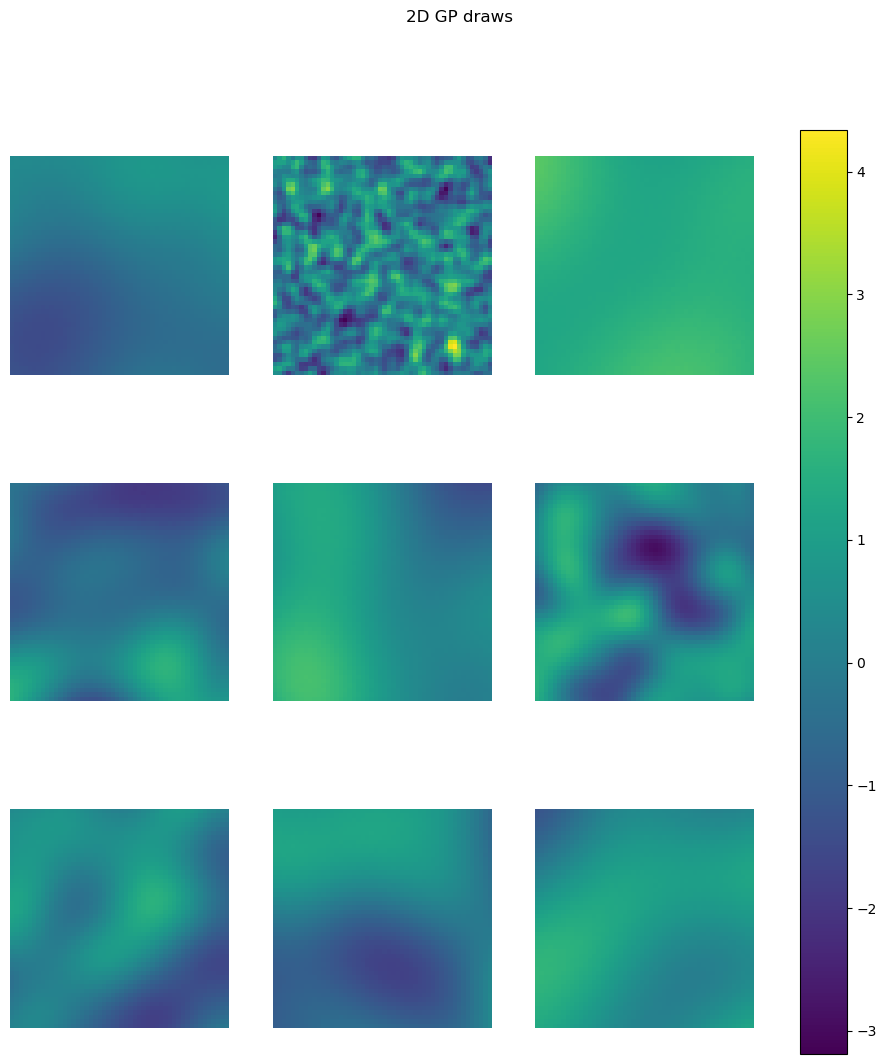

In [18]:
from reusable.gp import OneDGP_UnifLS
from plotting.plots import plot_2d_draws

rng_key, rng_key_plots = random.split(rng_key, 2)

to_plot = 9

plot_pred = Predictive(OneDGP_UnifLS, num_samples=to_plot)
plot_samples = plot_pred(rng_key_plots, x=args["x"], gp_kernel=args["gp_kernel"], jitter=5e-5)

plot_2d_draws(plot_samples["y"].reshape(-1, *([args["n"]] * args["dim"])), to_plot, 3, "2D GP draws")


In [6]:
if not args["pretrained_vae"]:
    from reusable.gp import OneDGP_UnifLS
    from reusable.data import gen_gp_batches

    
    rng_key, rng_key_train, rng_key_test = random.split(rng_key, 3)
    # generate a complete set of training and test data

    # NOTE changed draw_access - y_c is [y,u] for this
    train_draws = gen_gp_batches(args["x"], OneDGP_UnifLS, args["gp_kernel"], args["train_num_batches"], args["batch_size"], rng_key_train, draw_access="y_c",  jitter=5e-5)
    test_draws = gen_gp_batches(args["x"], OneDGP_UnifLS, args["gp_kernel"], 1, args["test_num_batches"]* args["batch_size"], rng_key_test, draw_access="y_c",  jitter=5e-5)


Looping, need 100
Used 100
Looping, need 200
Used 200


In [7]:
from reusable.vae import VAE
from reusable.train_nn import SimpleTrainState
import optax

rng_key, rng_key_init, rng_key_train = random.split(rng_key, 3)

module = VAE(
    hidden_dim1=args["hidden_dim1"],
    hidden_dim2=args["hidden_dim2"],
    latent_dim=args["latent_dim"],
    out_dim=args["n"] ** args["dim"],
    conditional=True,
)
params = module.init(rng_key, jnp.ones((args["batch_size"], args["n"] ** args["dim"] +1,)))["params"]  # initialize parameters by passing a template image
tx = optax.adam(args["learning_rate"])
state = SimpleTrainState.create(apply_fn=module.apply, params=params, tx=tx, key = rng_key_init)


epoch: 1, test_loss: 0.8829401731491089, train_loss: 0.8820434212684631
epoch: 6, test_loss: 0.8505460023880005, train_loss: 0.8465333580970764
epoch: 11, test_loss: 0.7414156198501587, train_loss: 0.7293708324432373
epoch: 16, test_loss: 0.6193335652351379, train_loss: 0.6008548736572266
epoch: 21, test_loss: 0.5626992583274841, train_loss: 0.541482150554657
epoch: 26, test_loss: 0.5449069142341614, train_loss: 0.5252565145492554
epoch: 31, test_loss: 0.5395786166191101, train_loss: 0.5214428305625916
epoch: 36, test_loss: 0.5382460355758667, train_loss: 0.5200411081314087
epoch: 41, test_loss: 0.5376437902450562, train_loss: 0.5186896920204163
epoch: 46, test_loss: 0.5356873869895935, train_loss: 0.5177222490310669
epoch: 51, test_loss: 0.5342656970024109, train_loss: 0.5154369473457336
epoch: 56, test_loss: 0.531271755695343, train_loss: 0.5112513303756714
epoch: 61, test_loss: 0.5269812941551208, train_loss: 0.5017035007476807
epoch: 66, test_loss: 0.5176312923431396, train_loss: 0

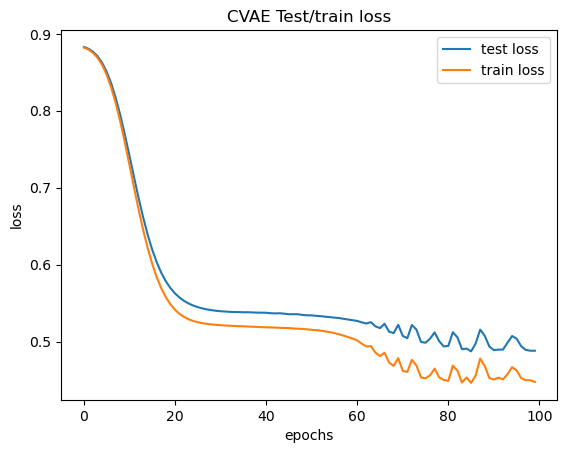

In [8]:
from reusable.loss import combo_loss, RCL, KLD, conditional_loss_wrapper

if not args["pretrained_vae"]:
    from reusable.train_nn import run_training

    state, metrics_history = run_training(conditional_loss_wrapper(combo_loss(RCL, KLD)), lambda *_: {}, args["num_epochs"], train_draws, test_draws, state)

    from plotting.plots import plot_training

    plot_training(metrics_history["test_loss"], metrics_history["train_loss"], "CVAE Test/train loss", note="loss")


### Training progress

comment 09/02/2023: why is there a shelf in the loss?, also, why is our test loss so closer to train loss?

In [9]:
from flax.core.frozen_dict import freeze
from reusable.util import decoder_filename, get_savepath

file_path = f'{get_savepath()}/{decoder_filename("14", args)}'

if not args["pretrained_vae"]:
    decoder_params = freeze({"params": state.params["VAE_Decoder_0"]})
    args["decoder_params"] = decoder_params
    with open(file_path, 'wb') as file:
       file.write(serialization.to_bytes(decoder_params))

if args["pretrained_vae"]:
    from reusable.vae import VAE_Decoder
    dummy_decoder = VAE_Decoder(hidden_dim1=args["hidden_dim1"],   hidden_dim2=args["hidden_dim2"], out_dim=args["n"])
    dummy_params = dummy_decoder.init(random.PRNGKey(0), jnp.ones((args["latent_dim"],)))
    with open(file_path, 'rb') as file:
        bytes = file.read()
        
        args["decoder_params"] = serialization.from_bytes(dummy_params, bytes)

## Demonstrations

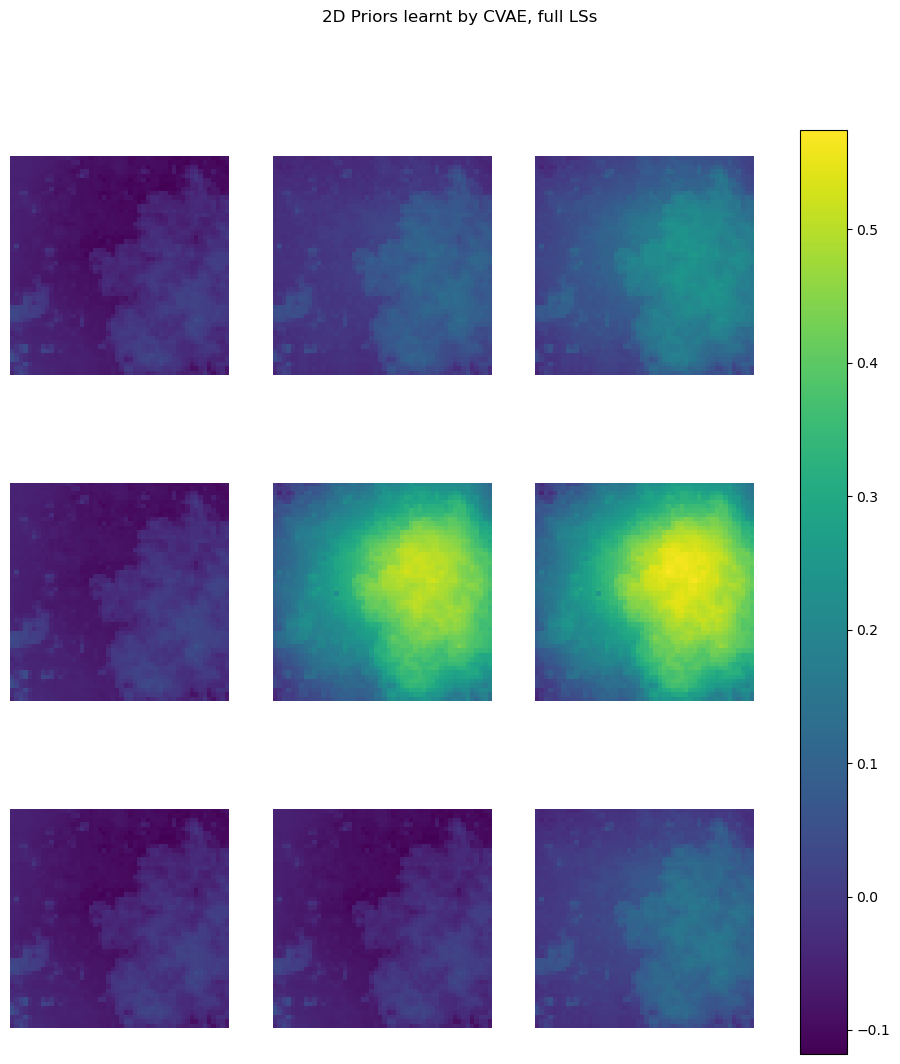

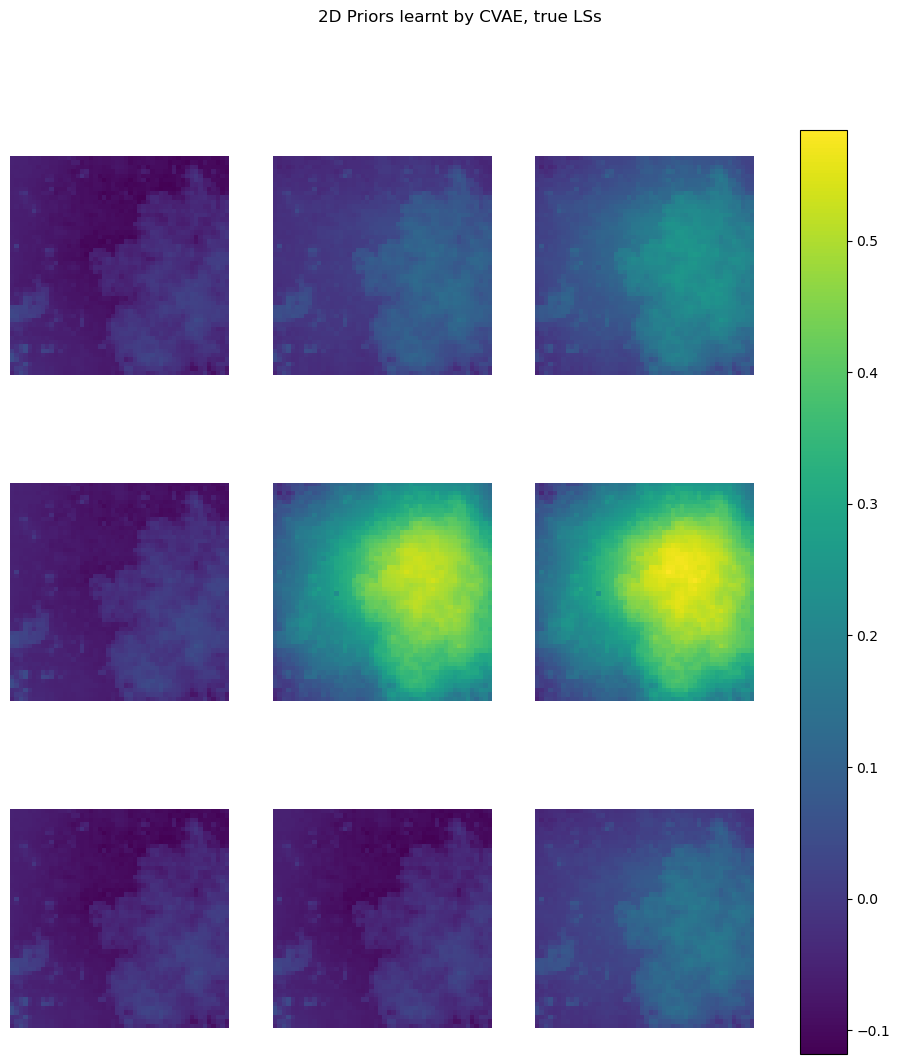

In [36]:
from reusable.vae import cvae_sample
from plotting.plots import compare_draws
rng_key, rng_key_predict = random.split(random.PRNGKey(2))

conditions = [(None, "full"), (0.05, "true"),]
for cond, label in conditions:

   
    plot_vae_predictive = Predictive(cvae_sample, num_samples=40)
    vae_draws = plot_vae_predictive(
        rng_key_predict,
        hidden_dim1=args["hidden_dim1"],
        hidden_dim2=args["hidden_dim2"],
        latent_dim=args["latent_dim"],
        out_dim=args["n"] ** args["dim"],
        decoder_params=args["decoder_params"],
        condition=cond
    )["f"]
    plot_2d_draws(jnp.reshape(vae_draws, (-1, *([args["n"]] * args["dim"]))), 9, 3, f"2D Priors learnt by CVAE, {label} LSs")


# Inference

In [41]:
import os
from  numpyro.infer import NUTS

def run_mcmc_cvae(rng_key, model_mcmc, y_obs, obs_idx, c=None, verbose=False):
    start = time.time()

    init_strategy = init_to_median(num_samples=10)
    kernel = NUTS(model_mcmc, init_strategy=init_strategy)
    mcmc = MCMC(
        kernel,
        num_warmup=args["num_warmup"],
        num_samples=args["num_samples"],
        num_chains=args["num_chains"],
        thinning=args["thinning"],
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )
    mcmc.run(
        rng_key,
        args["hidden_dim1"],
        args["hidden_dim2"],
        args["latent_dim"],
        args["n"] ** args["dim"],
        args["decoder_params"],
        y=y_obs,
        obs_idx=obs_idx,
        length=c
    )
    if verbose:
        mcmc.print_summary(exclude_deterministic=False)

    print("\nMCMC elapsed time:", time.time() - start)

    return mcmc.get_samples()


Ground truth - true ls = 0.05

300
(2500,)


(-3.0683934688568115, 2.852506160736084)

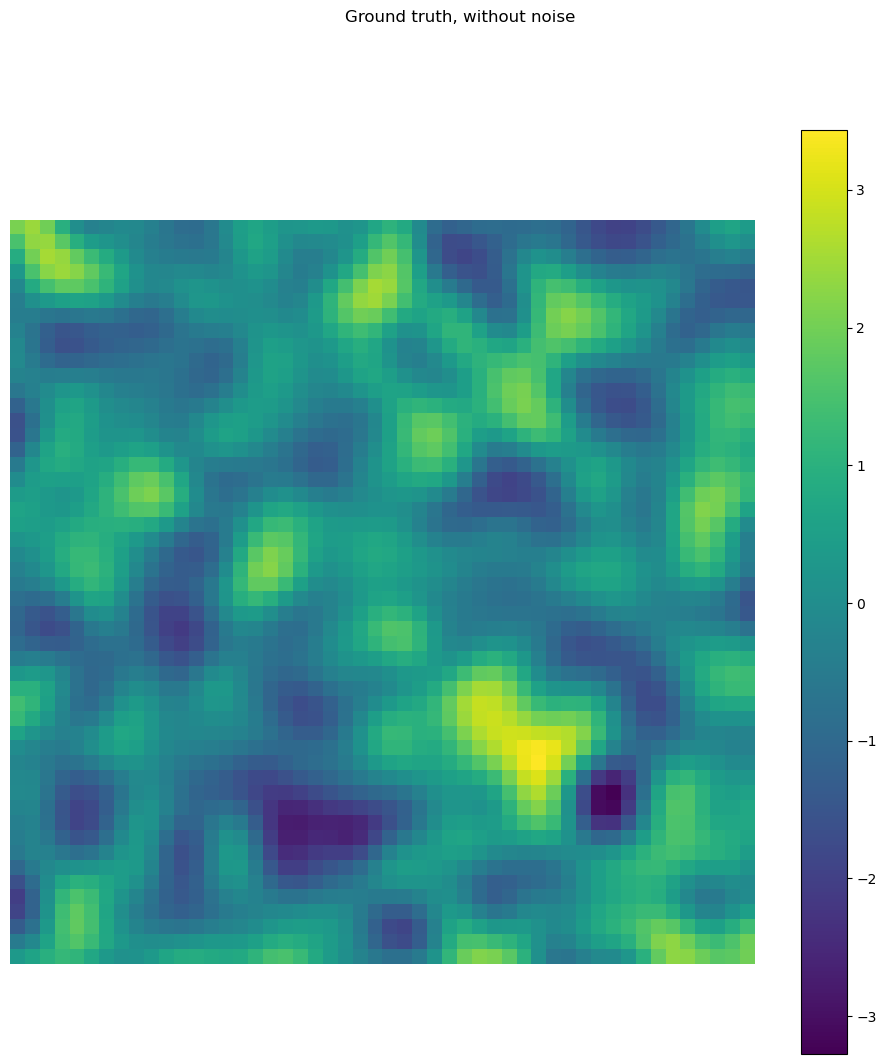

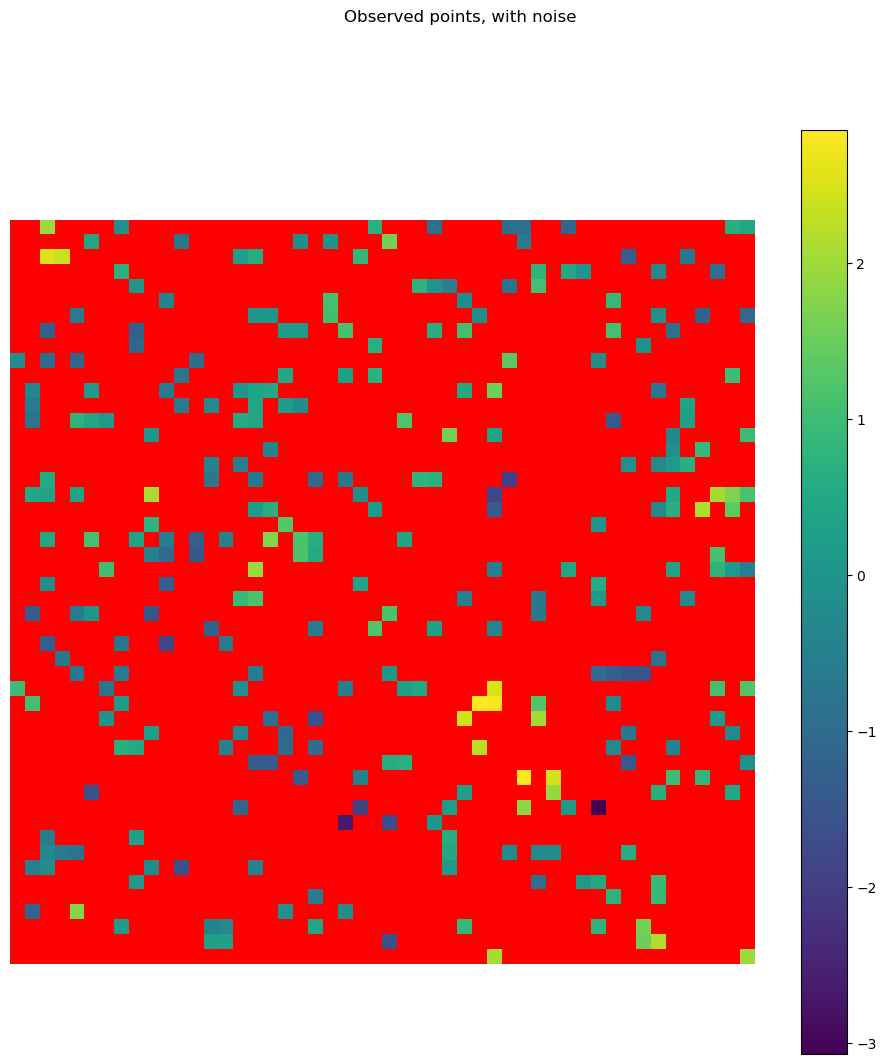

In [42]:
from reusable.gp import OneDGP_UnifLS
from plotting.plots import plot_2d_one_draw
rng_key_ground_truth = random.PRNGKey(
    4
)  # fixed to generate a "ground truth" GP we will try and infer

ground_truth_predictive = Predictive(OneDGP_UnifLS, num_samples=1)
gt_draws = ground_truth_predictive(
    rng_key_ground_truth, x=args["x"], gp_kernel=args["gp_kernel"], jitter=1e-5, noise=True, length=0.05
)
ground_truth = gt_draws["f"][0]
ground_truth_y_draw = gt_draws["y"][0]

obs_idx = jnp.array([2,7,24,28,33,34,37,48,49,55,61,69,71,75,84,102,103,115,116,123,141,145,157,185,187,188,193,197,208,227,228,229,233,235,260,271,280,290,304,316,317,321,331,343,346,349,352,358,368,369,372,378,380,390,394,408,424,442,450,452,454,462,483,489,511,518,522,524,548,551,555,560,565,566,567,580,582,593,601,611,613,616,618,619,645,651,654,655,656,665,666,676,690,695,709,729,732,744,749,767,794,796,813,815,841,843,844,845,852,863,866,870,872,877,878,883,901,902,904,909,923,932,944,947,948,949,966,967,974,982,993,994,996,998,1009,1018,1039,1052,1055,1058,1060,1062,1064,1067,1069,1070,1076,1109,1110,1112,1119,1120,1147,1156,1166,1182,1187,1194,1197,1198,1199,1202,1210,1223,1239,1265,1266,1280,1285,1289,1295,1301,1304,1305,1309,1325,1335,1342,1363,1370,1374,1378,1382,1402,1407,1410,1414,1453,1493,1504,1507,1516,1525,1539,1540,1541,1542,1550,1556,1565,1572,1576,1577,1582,1597,1599,1601,1607,1631,1632,1635,1640,1656,1667,1670,1680,1685,1697,1709,1715,1718,1741,1748,1757,1758,1764,1768,1770,1781,1790,1794,1816,1817,1825,1826,1841,1849,1869,1873,1884,1886,1894,1896,1905,1930,1936,1943,1948,1965,1973,1979,1984,1987,1989,2022,2025,2028,2052,2058,2079,2102,2103,2104,2129,2133,2135,2136,2141,2151,2152,2159,2161,2166,2179,2208,2235,2238,2239,2243,2270,2290,2293,2301,2304,2318,2322,2357,2363,2364,2370,2380,2389,2392,2413,2414,2425,2442,2443,2482,2499]) # indexing into flattened array
obs_mask = jnp.isin(jnp.arange(0, args["n"] **args["dim"]), obs_idx, assume_unique=True)
print(obs_mask.sum())

ground_truth_y_obs = ground_truth_y_draw[obs_idx]
x_obs = jnp.arange(0, args["n"] **args["dim"])[obs_idx]


print(ground_truth.shape)
vmin, vmax = plot_2d_one_draw(ground_truth.reshape(([args["n"]] * args["dim"])), "Ground truth, without noise")
plot_2d_one_draw(ground_truth.reshape(([args["n"]] * args["dim"])), "Observed points, with noise", vmin=vmin, vmax=vmax, mask=~obs_mask )

# plt.plot(args["x"], ground_truth, label="ground truth, without noise", color="orange")
# plt.scatter(x_obs, gt_y_obs, color="red", label="observed data (incl. noise)", s=60)
# plt.title('Ground truth, corresponds to c=1')
# plt.legend()

## Inference: assume correct LS

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


MCMC elapsed time: 5.512165307998657


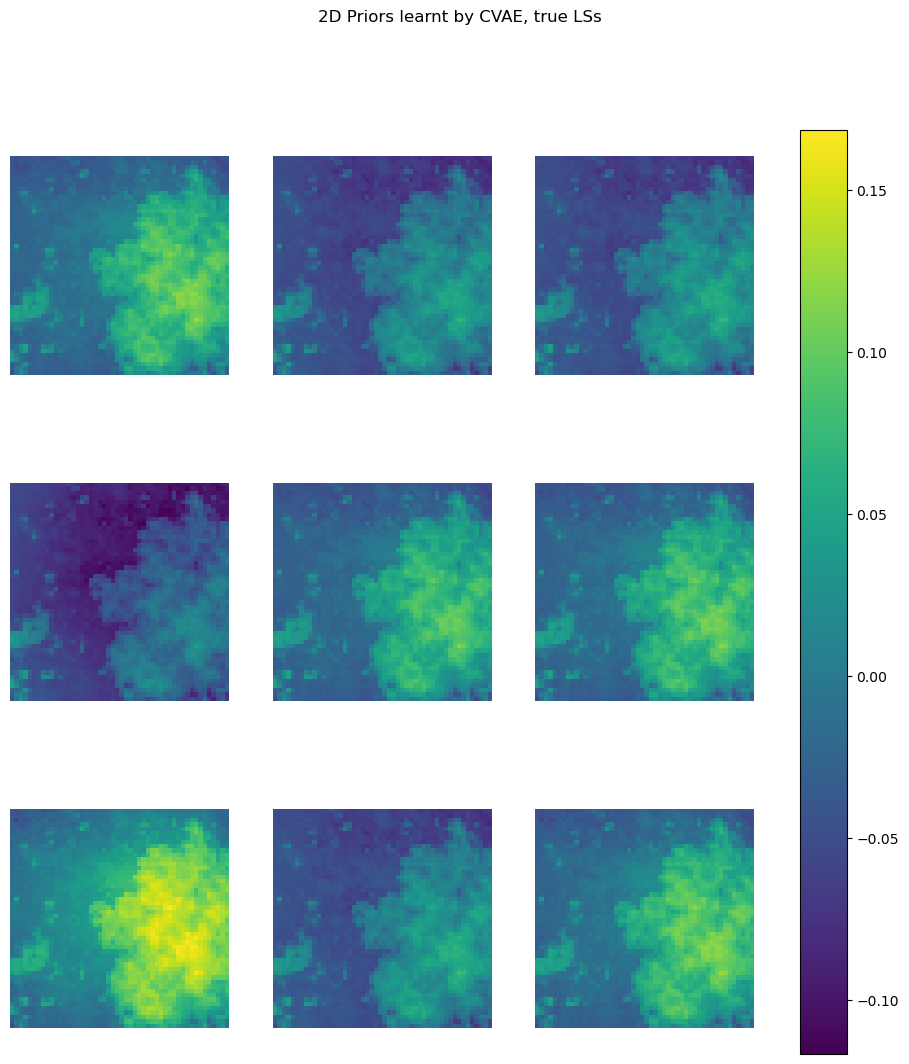

In [43]:
from reusable.vae import cvae_length_mcmc

rng_key, rng_key_prior, rng_key_post, rng_key_pred = random.split(rng_key, 4)

mcmc_samples = run_mcmc_cvae(rng_key_post, cvae_length_mcmc, ground_truth_y_obs, obs_idx, c=1)

predictive = Predictive(cvae_length_mcmc, mcmc_samples)

predictions = predictive(rng_key_pred, hidden_dim1=args["hidden_dim1"],
        hidden_dim2=args["hidden_dim2"],
        latent_dim=args["latent_dim"],
        out_dim=args["n"] ** args["dim"],
        decoder_params=args["decoder_params"], length=0.01)["f"]


plot_2d_draws(jnp.reshape(predictions, (-1, *([args["n"]] * args["dim"]))), 9, 3, f"2D Priors learnt by CVAE, {label} LSs")

## Inference: assume no LS

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


MCMC elapsed time: 6.615211725234985


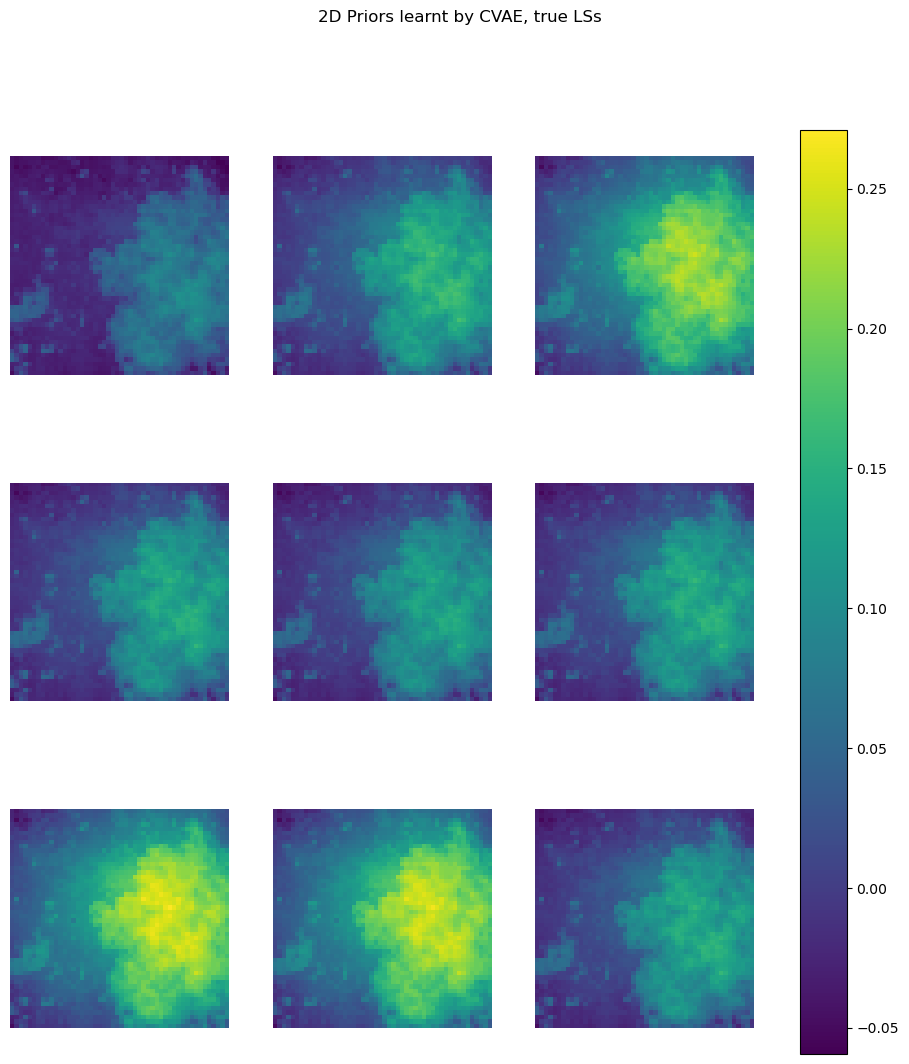

In [44]:
from reusable.vae import cvae_length_mcmc

rng_key, rng_key_prior, rng_key_post, rng_key_pred = random.split(rng_key, 4)

mcmc_samples = run_mcmc_cvae(rng_key_post, cvae_length_mcmc, ground_truth_y_obs, obs_idx, c=None)

predictive = Predictive(cvae_length_mcmc, mcmc_samples)

predictions = predictive(rng_key_pred, hidden_dim1=args["hidden_dim1"],
        hidden_dim2=args["hidden_dim2"],
        latent_dim=args["latent_dim"],
        out_dim=args["n"] ** args["dim"],
        decoder_params=args["decoder_params"], length=0.01)["f"]


plot_2d_draws(jnp.reshape(predictions, (-1, *([args["n"]] * args["dim"]))), 9, 3, f"2D Priors learnt by CVAE, {label} LSs")



# Posterior of lengthscale condition

Text(0.5, 1.0, 'c - posterior samples')

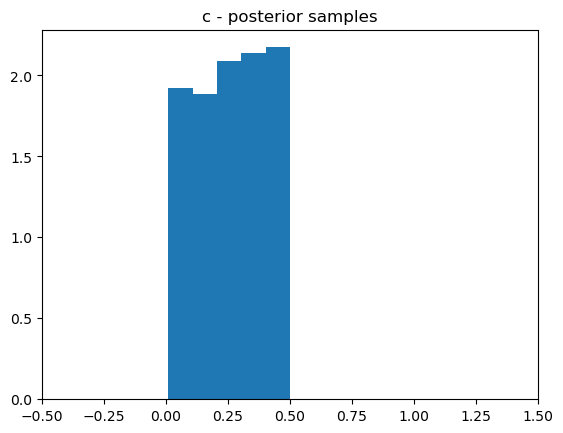

In [46]:
import matplotlib.pyplot as plt
c_samps = mcmc_samples['c']
plt.hist(c_samps, density=True, bins=5) 
plt.xlim(-0.5,1.5)
plt.title('c - posterior samples')